# 📘 Projeto de Algoritmos em Grafos
### Alunos: Arthur Soares Marques, Matheus Gomes Monteiro

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
# Função leitor_arquivo

def leitor_arquivo(path):
    try:
        with open(path, "r", encoding="utf-8") as arquivo:
            linhas = arquivo.readlines()
    except FileNotFoundError:
        print(f"Erro: Arquivo '{path}' não encontrado.")
        exit()
    except Exception as e:
        print(f"Erro ao ler o arquivo: {e}")
        exit()

    vertices = set()
    arestas = set()
    arcos = set()
    vertices_requeridos = set()
    arestas_requeridas = set()
    arcos_requeridos = set()
    secao_atual = None

    for linha in linhas:
        linha = linha.strip()

        if not linha or linha.startswith("//") or linha.startswith("Name:"):
            continue

        if linha.startswith("ReN."):
            secao_atual = "ReN"
            continue
        elif linha.startswith("ReE."):
            secao_atual = "ReE"
            continue
        elif linha.startswith("EDGE"):
            secao_atual = "EDGE"
            continue
        elif linha.startswith("ReA."):
            secao_atual = "ReA"
            continue
        elif linha.startswith("ARC"):
            secao_atual = "ARC"
            continue

        if linha and secao_atual:
            partes = linha.split("\t")
            try:
                if secao_atual == "ReN":
                    vertice = int(partes[0].replace("N", ""))
                    demanda = int(partes[1])
                    custo_servico = int(partes[2])
                    vertices_requeridos.add((vertice, (demanda, custo_servico)))
                    vertices.add(vertice)

                elif secao_atual in ["ReE", "EDGE"]:
                    origem, destino = int(partes[1]), int(partes[2])
                    vertices.update([origem, destino])
                    aresta = (min(origem, destino), max(origem, destino))
                    custo_transporte = int(partes[3])
                    arestas.add((aresta, custo_transporte))

                    if secao_atual == "ReE":
                        demanda = int(partes[4])
                        custo_servico = int(partes[5])
                        arestas_requeridas.add((aresta, (custo_transporte, demanda, custo_servico)))

                elif secao_atual in ["ReA", "ARC"]:
                    origem, destino = int(partes[1]), int(partes[2])
                    vertices.update([origem, destino])
                    arco = (origem, destino)
                    custo_transporte = int(partes[3])
                    arcos.add((arco, custo_transporte))

                    if secao_atual == "ReA":
                        demanda = int(partes[4])
                        custo_servico = int(partes[5])
                        arcos_requeridos.add((arco, (custo_transporte, demanda, custo_servico)))
            except ValueError:
                print(f"Erro ao processar linha: {linha}")
                continue

    if not vertices:
        print("Erro: Nenhum vértice encontrado no arquivo.")
        exit()

    return vertices, arestas, arcos, vertices_requeridos, arestas_requeridas, arcos_requeridos

In [7]:
# Outras funções utilitárias

def validar_grafo(vertices, arestas, arcos):
    for (u, v), _ in arestas:
        if u not in vertices or v not in vertices:
            print(f"Erro: Aresta ({u}, {v}) contém vértices inexistentes.")
            exit()

    for (u, v), _ in arcos:
        if u not in vertices or v not in vertices:
            print(f"Erro: Arco ({u}, {v}) contém vértices inexistentes.")
            exit()

def calcula_graus(vertices, arestas, arcos):
    grausT = {v: [0, 0, 0] for v in vertices}
    for (u, v), _ in arestas:
        grausT[u][0] += 1
        grausT[v][0] += 1
    for (u, v), _ in arcos:
        grausT[u][2] += 1
        grausT[v][1] += 1
    return tuple((v, tuple(g)) for v, g in grausT.items())

def calcular_densidade(num_vertices, num_arestas, num_arcos):
    arestasT = (num_vertices * (num_vertices - 1)) / 2
    arcosT = num_vertices * (num_vertices - 1)
    if num_vertices < 2:
        return 0
    if arestasT == 0 or arcosT == 0:
        return 0
    return (num_arestas + num_arcos) / (arestasT + arcosT)

def floyd_warshall(vertices, arestas, arcos):
    distancias = {v: {u: float('inf') for u in vertices} for v in vertices}
    predecessores = {v: {u: None for u in vertices} for v in vertices}
    for v in vertices:
        distancias[v][v] = 0
    for (u, v), custo in arestas:
        distancias[u][v] = custo
        distancias[v][u] = custo
        predecessores[u][v] = u
        predecessores[v][u] = v
    for (u, v), custo in arcos:
        distancias[u][v] = custo
        predecessores[u][v] = u
    for k in vertices:
        for i in vertices:
            for j in vertices:
                if distancias[i][j] > distancias[i][k] + distancias[k][j]:
                    distancias[i][j] = distancias[i][k] + distancias[k][j]
                    predecessores[i][j] = predecessores[k][j]
    return distancias, predecessores

def criar_matriz_distancias(vertices, arestas, arcos):
    distancias, _ = floyd_warshall(vertices, arestas, arcos)
    return distancias

def criar_matriz_predecessores(vertices, arestas, arcos):
    _, predecessores = floyd_warshall(vertices, arestas, arcos)
    return predecessores

def caminho_minimo(matriz_pred, origem, destino):
    caminho = []
    atual = destino
    while atual is not None:
        caminho.insert(0, atual)
        if atual == origem:
            break
        atual = matriz_pred[origem].get(atual)
    if caminho[0] != origem:
        return []
    return caminho

def calcular_diametro(matriz_dist):
    diametro = 0
    for d in matriz_dist.values():
        dist_max = max(v for v in d.values() if v < float('inf'))
        diametro = max(diametro, dist_max)
    return diametro

def calcular_caminho_medio(num_vertices, matriz_dist):
    soma = 0
    for linha in matriz_dist.values():
        for valor in linha.values():
            if valor < float('inf'):
                soma += valor
    return soma / (num_vertices * (num_vertices - 1))

def calcular_intermediacao(vertices, matriz_pred):
    intermediacao = {v: 0 for v in vertices}
    for origem in vertices:
        for destino in vertices:
            if origem != destino:
                caminho = caminho_minimo(matriz_pred, origem, destino)
                for v in caminho[1:-1]:
                    intermediacao[v] += 1
    return intermediacao

In [8]:
from google.colab import files

uploaded = files.upload()

path = "BHW10.dat"

vertices, arestas, arcos, vertices_req, arestas_req, arcos_req = leitor_arquivo(path)



Saving BHW10.dat to BHW10 (1).dat


In [9]:
# Estrutura do grafo com pandas

df_vertices = pd.DataFrame(sorted(list(vertices)), columns=["Vértices"])
df_arestas = pd.DataFrame([(u, v, custo) for ((u, v), custo) in arestas], columns=["Origem", "Destino", "Custo"])
df_arcos = pd.DataFrame([(u, v, custo) for ((u, v), custo) in arcos], columns=["Origem", "Destino", "Custo"])

display(df_vertices)
display(df_arestas)
display(df_arcos)

,Vértices
0,1
1,2
2,3
3,4
4,5
5,6
6,7
7,8
8,9
9,10


,Origem,Destino,Custo
0,7,12,18
1,5,12,11
2,8,11,10
3,2,9,2
4,2,3,18
5,7,8,8
6,10,11,12
7,9,10,16
8,5,11,20
9,2,4,9


,Origem,Destino,Custo
0,4,3,20
1,9,11,14
2,6,12,3
3,10,1,19
4,5,3,5
5,1,4,17
6,6,7,4
7,2,1,13
8,11,9,14
9,8,10,3


In [10]:
# Métricas do grafo

densidade = calcular_densidade(len(vertices), len(arestas), len(arcos))
matriz_dist = criar_matriz_distancias(vertices, arestas, arcos)
matriz_pred = criar_matriz_predecessores(vertices, arestas, arcos)
diametro = calcular_diametro(matriz_dist)
caminho_medio = calcular_caminho_medio(len(vertices), matriz_dist)
graus = calcula_graus(vertices, arestas, arcos)
intermediacao = calcular_intermediacao(vertices, matriz_pred)

In [11]:
# Exibição das métricas

df_graus = pd.DataFrame([(v, g[0], g[1], g[2], sum(g)) for v, g in graus],
                        columns=["Vértice", "Grau", "Entrada", "Saída", "Grau Total"])
df_intermediacao = pd.DataFrame(intermediacao.items(), columns=["Vértice", "Intermediação"])
df_metrica = pd.DataFrame({
    "Métrica": ["Total Vértices", "Total Arestas", "Total Arcos", "Densidade", "Diâmetro", "Caminho Médio"],
    "Valor": [len(vertices), len(arestas), len(arcos), densidade, diametro, caminho_medio]
})

display(df_graus.sort_values("Vértice"))
display(df_intermediacao.sort_values("Intermediação", ascending=False))
display(df_metrica)

,Vértice,Grau,Entrada,Saída,Grau Total
0,1,0,5,5,10
1,2,3,1,1,5
2,3,1,2,2,5
3,4,1,2,2,5
4,5,3,1,1,5
5,6,1,2,2,5
6,7,2,2,2,6
7,8,2,1,1,4
8,9,2,1,1,4
9,10,2,2,2,6


,Vértice,Intermediação
5,6,38
1,2,22
6,7,22
11,12,22
0,1,18
7,8,16
4,5,14
8,9,14
9,10,6
2,3,6


,Métrica,Valor
0,Total Vértices,12.000000
1,Total Arestas,11.000000
2,Total Arcos,22.000000
3,Densidade,0.166667
4,Diâmetro,30.000000
5,Caminho Médio,16.712121


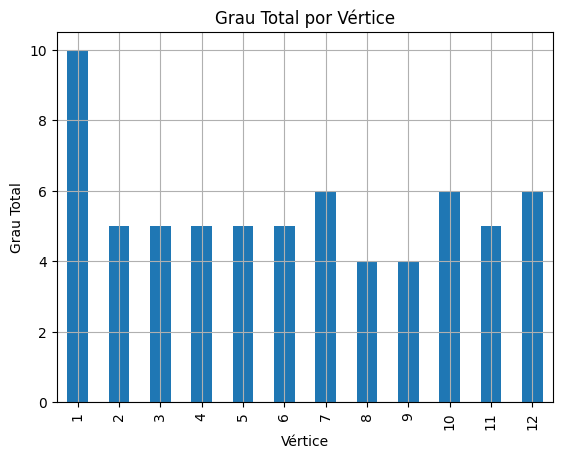

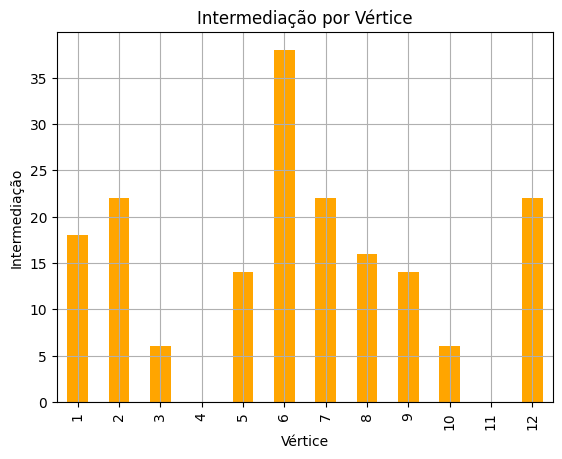

In [12]:
# Visualizações opcionais com matplotlib

df_graus.plot.bar(x="Vértice", y="Grau Total", legend=False, title="Grau Total por Vértice")
plt.ylabel("Grau Total")
plt.grid(True)
plt.show()

df_intermediacao.plot.bar(x="Vértice", y="Intermediação", legend=False, title="Intermediação por Vértice", color="orange")
plt.ylabel("Intermediação")
plt.grid(True)
plt.show()